## Trading Strategy - TrendFollwing 

策略核心理念：
- 趨勢追蹤策略是建立於當市場供需失衡時，股價通常會朝著同一方向持續移動一段時間的現象。
- 策略旨在捕捉股價大部分的上漲與下跌段，而不試圖猜頭摸底。當價格開始沿著特定方向移動時，策略會順勢買進或放空股票，而在趨勢消失時賣出或回補股票。
- 策略也會搭配追踪止利止損出場與持股比例配置調整，用以控制策略的波動度，保持可接受的風險。

### 一. 環境設定 & import package

1.1 輸入tejapi key

In [1]:
import os
os.environ['TEJAPI_KEY'] = "your key" 
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

1.2 import package

In [3]:
import pandas as pd
import numpy as np
import pytz
# from datetime import datetime
import matplotlib.pyplot as plt
# import matplotlib

import zipline
from zipline.data import bundles
from zipline.utils.calendar_utils import get_calendar

from zipline.api import    *
from zipline.finance.commission import PerDollar,PerShare, PerTrade, PerContract
from zipline.finance.slippage import VolumeShareSlippage, FixedSlippage, VolatilityVolumeShare

from zipline.sources.TEJ_Api_Data import (get_Treasury_Return,
                                          get_Benchmark_Return)

from zipline.utils.run_algo import  (get_transaction_detail,
                                     get_record_vars)
import pyfolio as pf

### 二、樣本&期間

2.1 設定股票池與期間
- 股票池：輸入81檔權值股與加權股價報酬指數(IR0001)
- 期間：從2012-2022年

In [4]:
# set stocklist---------------------------------------------------
StockList = \
['1101', '1102', '1216', '1301', '1303', '1326', '1402', '1722', '2002', '2105', '2201', '2207', '2301',
 '2303', '2308', '2311', '2317', '2324', '2325', '2330', '2347', '2353', '2354', '2357', '2382', '2409',
 '2412', '2454', '2474', '2498', '2801', '2880', '2881', '2882', '2883', '2885', '2886', '2890', '2891',
 '2892', '2912', '3008', '3045', '3231', '3481', '3673', '3697', '4904', '5880', '6505', '2884', '4938',
 '2887', '2227', '9904', '3474', '2395', '2408', '1476', '2823', '2633', '5871', '2327', '3711', '2492',
 '5876', '9910', '2888', '6669', '2379', '6415', '3034', '1590', '8046', '2603', '2609', '2615', '8454',
 '3037', '6770', '1605', 'IR0001']

# set backtest period----------------------------------------------
start='2012-01-01'
end='2023-07-30'

start_dt, end_dt = pd.Timestamp(start, tz = pytz.utc), pd.Timestamp(end, tz = pytz.utc)

2.2 樣本與期間設定輸入，並利用tejapi將開高低收量、調整股價資料綁入zipline
- 綁入名稱為`tquant的資料庫`，並指定交易日為`台股交易日誌:TEJ_XTAI`

In [5]:
os.environ['ticker'] = ' '.join(StockList)
os.environ['mdate'] = start+' '+end

In [14]:
!zipline ingest -b tquant

Merging daily equity files:


[2023-08-07 02:39:24.408027] INFO: zipline.data.bundles.core: Ingesting tquant.


In [6]:
# calendar------------------------------------------
calendar_name='TEJ_XTAI'  
# bundle_name---------------------------------------
bundle_name = 'tquant'

### 三、建構交易策略
交易策略包含：進出場規則設定、持股配置、交易頻率，以及交易費用設定
- **進出場規則**
    - 趨勢filter
        - 利用指標作為過濾器，判斷股票的趨勢方向。
        - 正向趨勢條件：短均線ema(40)>長均線ema(80)。
        - 負向趨勢條件：短均線ema(40)<長均線ema(80)。
    - 進場rule
        - Long Entry:
            - 當趨勢為正且股價突破過去50日新高時，買進股票。            
        - Short Entry:
            - 當趨勢為負且股價跌破過去50日新低時，放空股票。            
    - 出場rule
        - Long Exit:
            - 當趨勢方向轉空，短均線ema(40)<長均線ema(80)，賣出股票。
            - 設定買進股票後，以價格高點下方3倍標準差的價格為追蹤停利停損點，當股價低於此點賣出股票。
        - Short Exit:
            - 當趨勢方向轉多，短均線ema(40)>長均線ema(80)，回補股票。
            - 設定放空股票後，以價格低點上方3倍標準差的價格為追蹤停利停損點，當股價高於此點賣出股票。
    
- **持股配置**
    - 旨要利用配置與調整持股權重，使每檔股票對策略每日風險的貢獻程度大致均等。
    - 由於不同股票其價格波動的幅度差異很大，若以等權重配置會使策略的風險高度偏斜於波動大個股票。
    - 本範例會利用近期股價波動的標準差來衡量風險，作為調整持股配置的依據。
    
- **交易頻率**
    - 交易頻率設定為日頻。每日確認交易訊號，決定買賣股票與調整持股部位。    - 
    
- **交易費用**
    - 設定單次買賣股票金額的0.29%為佣金費用
    - 設定0%為滑價成本 
   


3.1 交易策略參數設定

In [7]:
# These lines are for the dynamic text reporting
from IPython.display import display
import ipywidgets as widgets
out = widgets.HTML()
display(out)

"""
Model Settings
"""
starting_portfolio = 10e6
risk_factor = 1
stop_distance = 3
breakout_window = 50
vola_window = 40
slow_ma = 80
fast_ma = 40

'''
cost params setting
'''
commission_pct = 0.0029
slippage_volume_limit = 1.0
slippage_impact = 0

HTML(value='')

3.2 交易策略初始化設定

In [8]:
def initialize(context):

    # trading cost setting-----------------------------------------------------------------------------
    set_commission(PerDollar(cost=commission_pct))
    set_slippage(VolumeShareSlippage(volume_limit=slippage_volume_limit, price_impact=slippage_impact)) 
     
    # Make a list of all continuations-----------------------------------------------------------------
    bundle_data = bundles.load('tquant')
    context.universe = bundle_data.asset_finder.retrieve_all(bundle_data.asset_finder.equities_sids)#.remove(symbol('IR0001'))   
    
    # setting benchmark
    set_benchmark(symbol('IR0001')) 
    
    # We'll use these to keep track of best position reading 
    #Used to calculate stop points.
    context.highest_in_position = {tick: 0 for tick in context.universe}  
    context.lowest_in_position = {tick: 0 for tick in context.universe}    
    
    # Schedule the daily trading
    schedule_function(daily_trade, date_rules.every_day(), time_rules.market_close())
    
    # We'll just use this for the progress output
    # during the backtest. Doesn't impact anything.
    context.months = 0    
    
    # Schedule monthly report output
    schedule_function(
        func=report_result,
        date_rule=date_rules.month_start(),
        time_rule=time_rules.market_open()
    ) 
def report_result(context, data):
    context.months += 1
    today = zipline.api.get_datetime().date()
    # Calculate annualized return so far
    ann_ret = np.power(context.portfolio.portfolio_value / starting_portfolio, 
                   12 / context.months) - 1
    
    # Update the text
    out.value = """{} We have traded {} months  and the annualized return is {:.2%}""".format(today, context.months, ann_ret)

3.3 持股配置與進出場規則設定

In [9]:
def position_size(portfolio_value, std, point_value=1):
    risk_factor = 0.01
    target_variation = portfolio_value * risk_factor
    contract_variation = std * point_value
    contracts = target_variation / contract_variation
    return int(np.nan_to_num(contracts)) 

def daily_trade(context, data):    
    
    today = data.current_session.date()  
    todays_universe = context.universe
    
    hist_close = data.history(todays_universe, ['close','volume'], bar_count=slow_ma  + 1, frequency='1d')['close']
    hist_volume = data.history(todays_universe, ['close','volume'], bar_count=slow_ma  + 1, frequency='1d')['volume']    
    
    for _asset in todays_universe:
        
        h_close = hist_close.unstack()[_asset]
        h_trend = hist_close.unstack()[_asset].ewm(span=fast_ma).mean() > hist_close.unstack()[_asset].ewm(span=slow_ma).mean()
        h_volume = hist_volume.unstack()[_asset]
        h_std = hist_close.unstack().pct_change().iloc[-vola_window:].std()[_asset]*100 
        
        if _asset in context.portfolio.positions:
            
            p = context.portfolio.positions[_asset]
            stop_distance = 3               
            
            if p.amount > 0: # Position is long
                
                if context.highest_in_position[_asset] == 0: # First day holding the position
                    context.highest_in_position[_asset] = p.cost_basis
                else:
                    context.highest_in_position[_asset] = max(
                        h_close.iloc[-1], context.highest_in_position[_asset]
                    )                 
                # Calculate stop point
                stop = context.highest_in_position[_asset] - (h_std  * stop_distance)
                
                # Check if stop is hit
                if h_close.iloc[-1] < stop:
                    order_target(_asset, 0)
                    context.highest_in_position[_asset] = 0
                # Check if trend has flipped
                elif h_trend.iloc[-1] == False:        
                    order_target(_asset, 0)
                    context.highest_in_position[_asset] = 0

            elif p.amount <0: # Position is short
                
                if context.lowest_in_position[_asset] == 0: # First day holding the position
                    context.lowest_in_position[_asset] = p.cost_basis
                else:
                    context.lowest_in_position[_asset] = min(
                        h_close.iloc[-1], context.lowest_in_position[_asset]
                    )
                # Calculate stop point
                stop = context.lowest_in_position[_asset] + (h_std  * stop_distance)
                
                # Check if stop is hit
                if h_close.iloc[-1] > stop:
                    order_target(_asset, 0)
                    context.lowest_in_position[_asset] = 0
                # Check if trend has flipped
                elif h_trend.iloc[-1] == True:
                    order_target(_asset, 0)
                    context.lowest_in_position[_asset] = 0 
           
        else: # No position on
            if _asset==symbol('IR0001'): continue
                
            if h_trend.iloc[-1]: # Bull trend
                # Check if we just made a new high
                if h_close.iloc[-1] == h_close[-breakout_window:].max(): 
                
                    volume_to_trade = position_size(context.portfolio.portfolio_value, h_std)
                    order_value(_asset, volume_to_trade)                    
             
            else: # Bear trend
                # Check if we just made a new low
                if  h_close.iloc[-1] == h_close[-breakout_window:].min(): 
                    #contract = data.current(continuation, 'contract')

                    volume_to_trade = position_size(context.portfolio.portfolio_value, h_std)
                    order_value(_asset,-1* volume_to_trade)            


3.4 取得Treasury資料，以第一銀行(5844)一年期定存利率作為無風險利率。

In [10]:
treasury_returns = get_Treasury_Return(start = start_dt,
                                      end = end_dt,
                                      rate_type = 'Time_Deposit_Rate',                     
                                      term = '1y',
                                      symbol = '5844')
treasury_returns

mdate
2012-01-02 00:00:00+00:00    0.000053
2012-01-03 00:00:00+00:00    0.000053
2012-01-04 00:00:00+00:00    0.000053
2012-01-05 00:00:00+00:00    0.000053
2012-01-06 00:00:00+00:00    0.000053
                               ...   
2023-07-24 00:00:00+00:00    0.000062
2023-07-25 00:00:00+00:00    0.000062
2023-07-26 00:00:00+00:00    0.000062
2023-07-27 00:00:00+00:00    0.000062
2023-07-28 00:00:00+00:00    0.000062
Length: 2835, dtype: float64

3.5 執行回測

<AxesSubplot:>

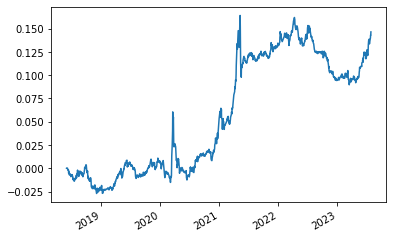

In [11]:
results = zipline.run_algorithm(
                start = pd.Timestamp('2018-06-01', tz='utc'), 
                end   = pd.Timestamp('2023-07-30', tz='utc'), 
                initialize=initialize,                 
                capital_base=starting_portfolio,  
                data_frequency = 'daily', 
                treasury_returns=treasury_returns,
                trading_calendar=get_calendar(calendar_name),
                bundle=bundle_name)
results.returns.cumsum().plot() 

### 4.策略績效分析
4.1 利用pyfolio分析評估策略的風險與報酬表現

Start date,2018-06-01
End date,2023-07-28
Total months,59
,Backtest
Annual return,2.875%
Cumulative returns,15.214%
Annual volatility,4.398%
Sharpe ratio,0.67
Calmar ratio,0.39
Stability,0.76
Max drawdown,-7.311%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,7.31,2021-05-10,2023-03-16,NaT,NaN
1,7.11,2020-03-19,2020-06-15,2021-01-11,213
2,3.03,2018-10-01,2018-12-04,2019-05-27,171
3,2.60,2019-12-18,2020-03-05,2020-03-13,63
4,2.26,2021-01-11,2021-02-01,2021-03-24,53


C:\Users\2020033001\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Stress Events,mean,min,max
New Normal,0.01%,-2.60%,2.04%


C:\Users\2020033001\AppData\Roaming\Python\Python38\site-packages\pandas\core\indexes\base.py:5278: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  start_slice, end_slice = self.slice_locs(start, end, step=step, kind=kind)


Top 10 long positions of all time,max
sid,
2609,4.39%
3231,3.72%
2603,3.64%
2382,2.77%
2883,2.64%
2880,2.52%
4904,2.51%
2884,2.46%
2801,2.41%


Top 10 short positions of all time,max
sid,
3045,-2.62%
4904,-2.31%
2412,-2.22%
2002,-2.14%
2801,-2.04%
1303,-1.85%
1102,-1.82%
2886,-1.72%
2227,-1.69%


Top 10 positions of all time,max
sid,
2609,4.39%
3231,3.72%
2603,3.64%
2382,2.77%
2883,2.64%
3045,2.62%
2880,2.52%
4904,2.51%
2884,2.46%


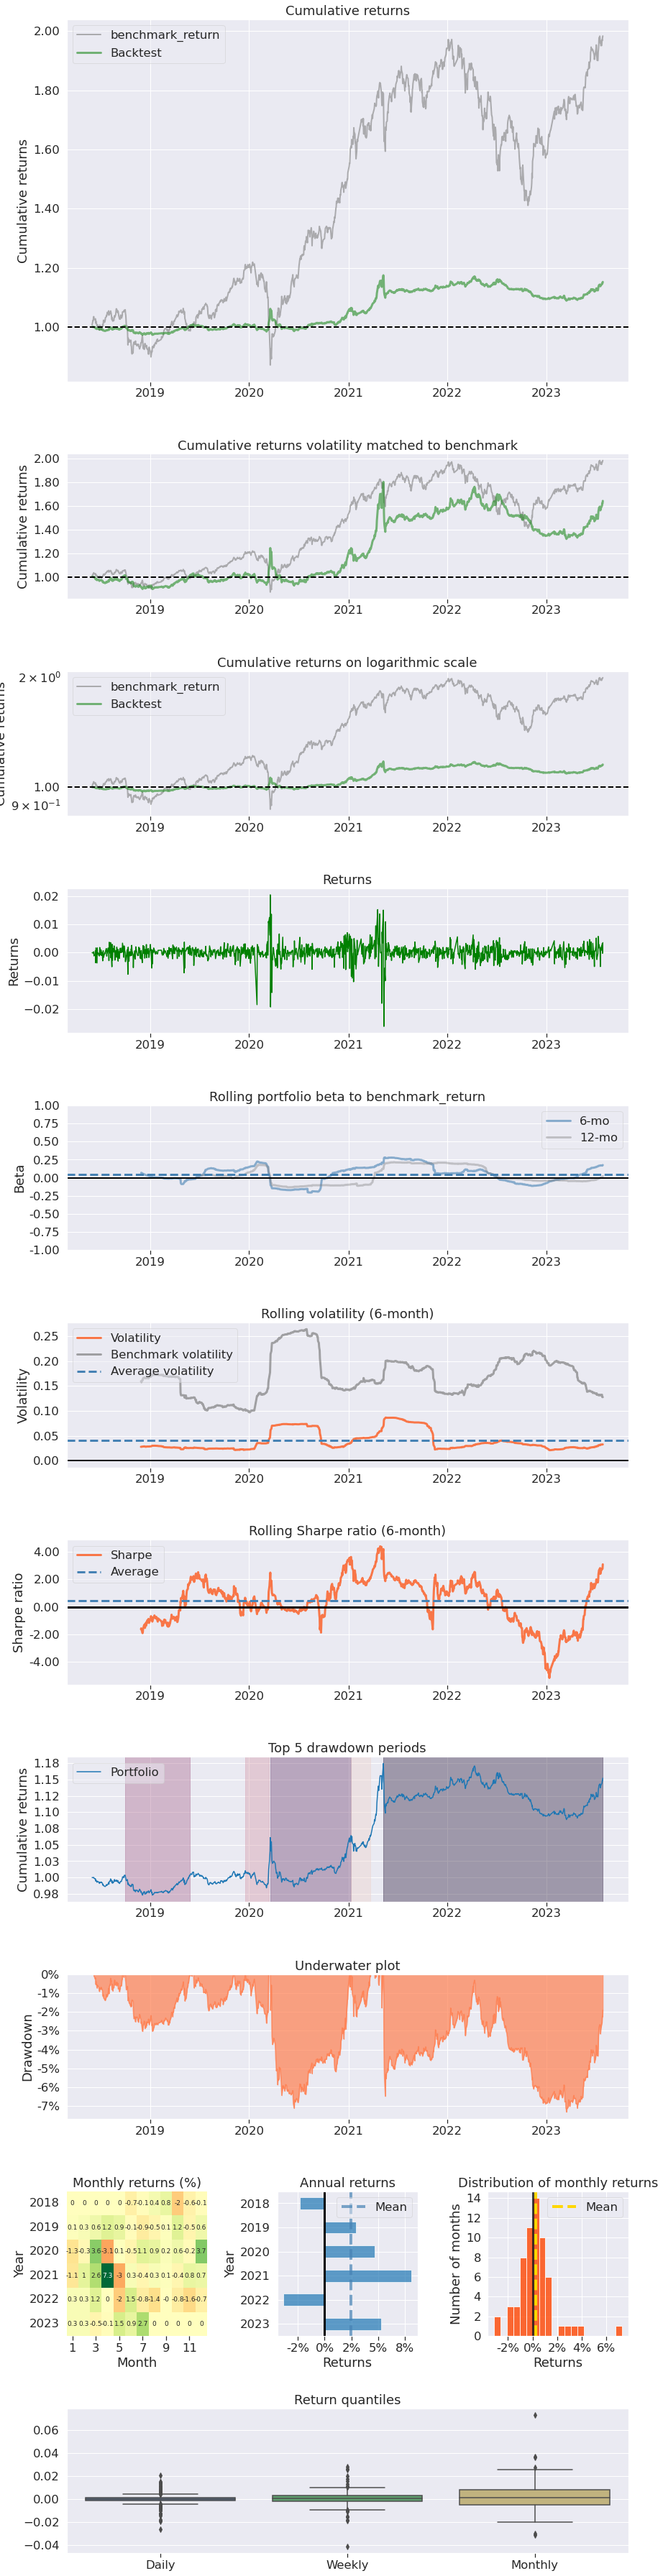

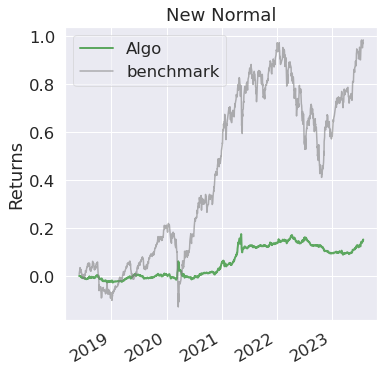

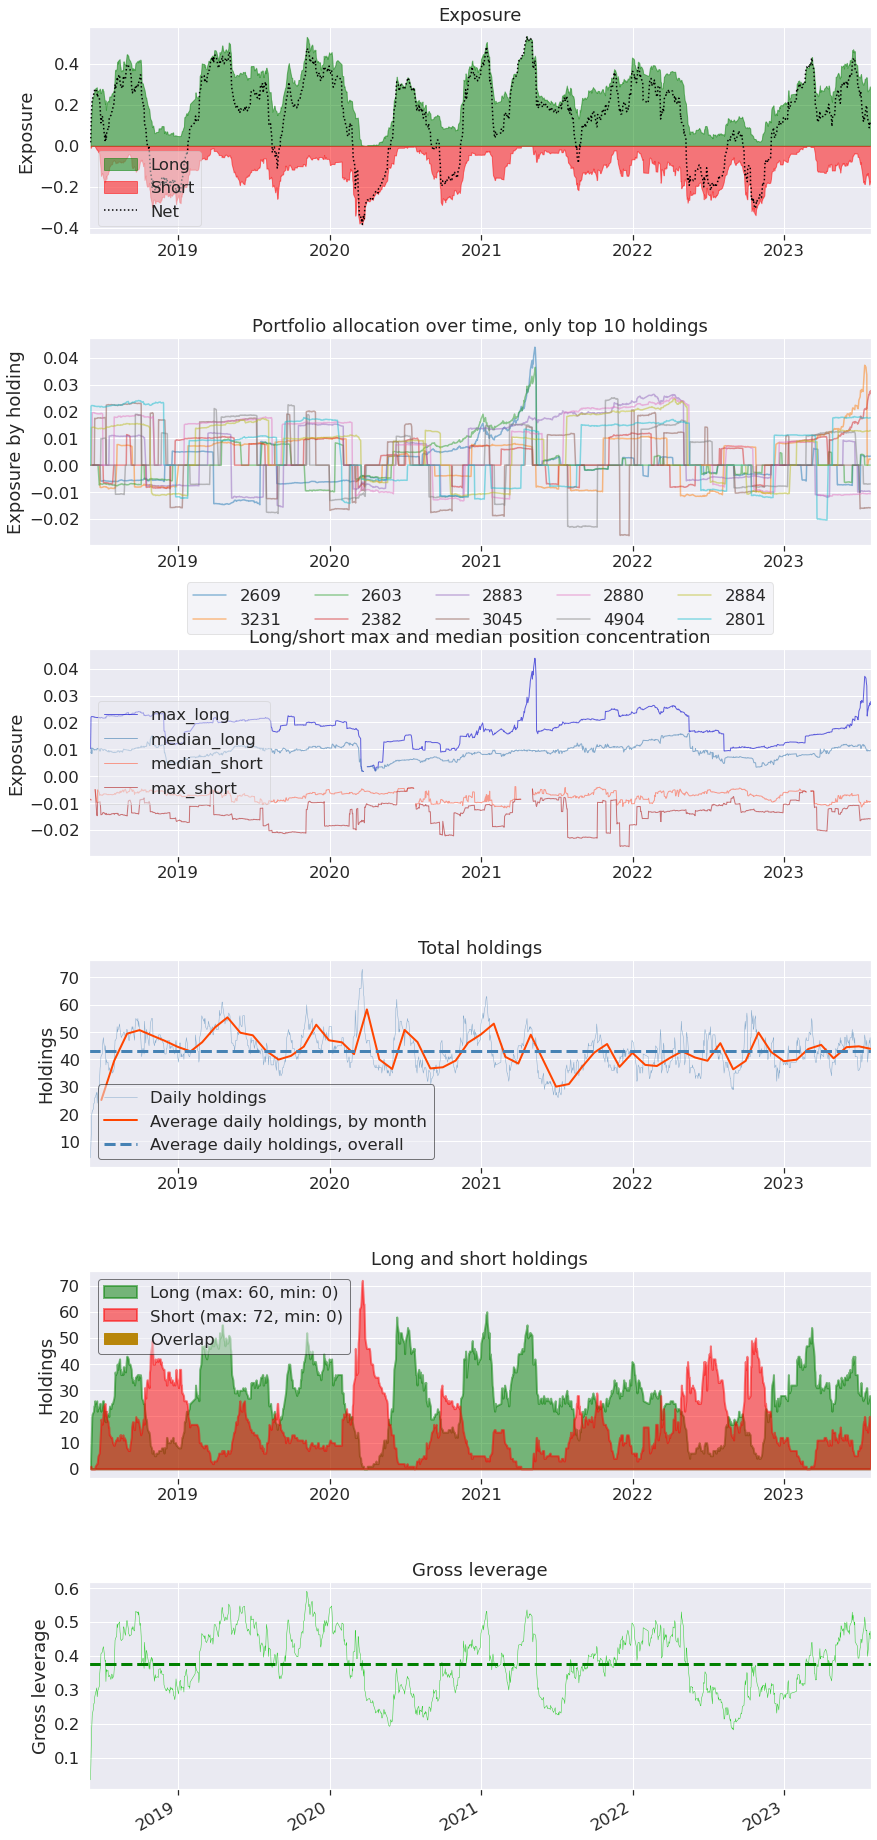

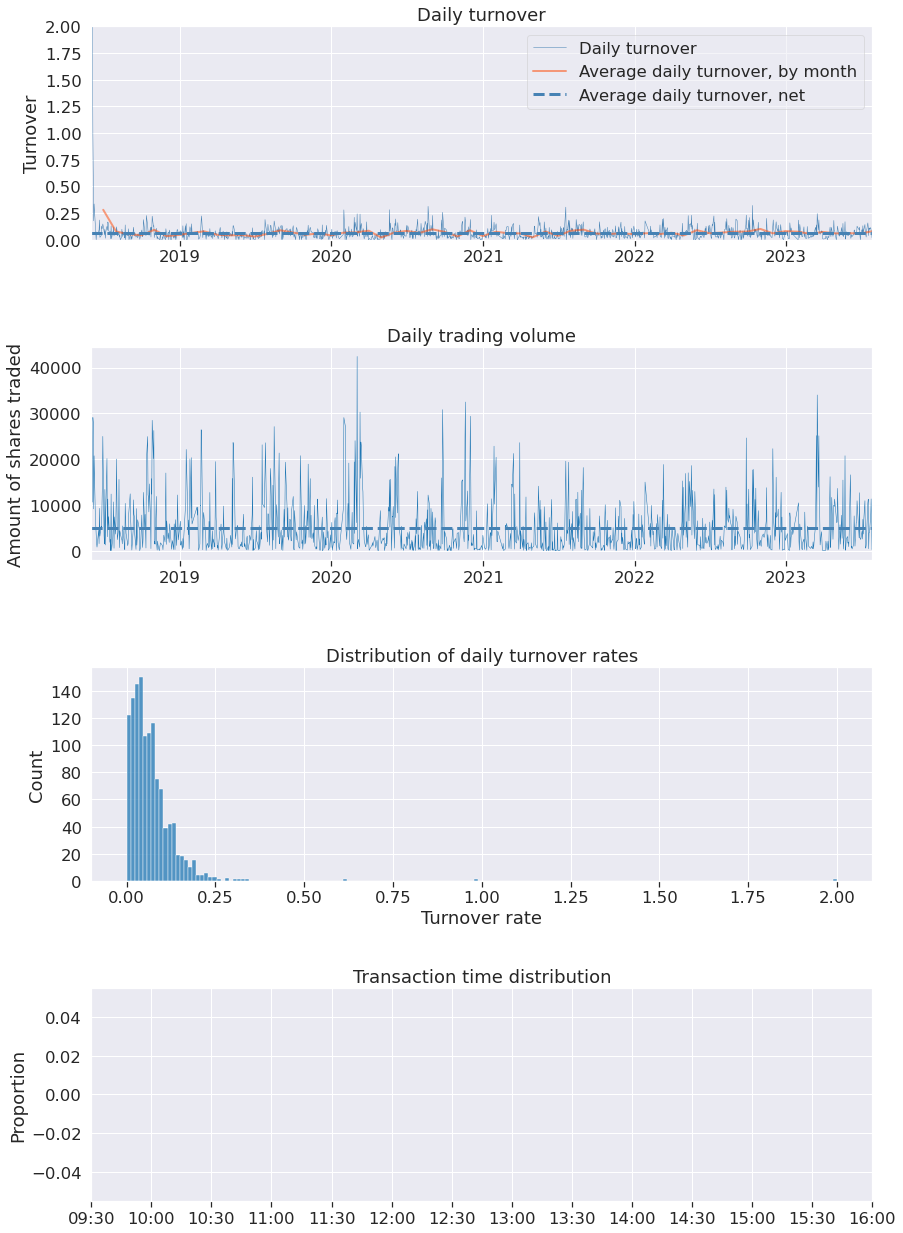

In [12]:
import pyfolio as pf
import empyrical

bt_returns, bt_positions, bt_transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results.benchmark_return

bt_returns.index = bt_returns.index.tz_localize(None).tz_localize('UTC')
bt_positions.index = bt_positions.index.tz_localize(None).tz_localize('UTC')
bt_transactions.index = bt_transactions.index.tz_localize(None).tz_localize('UTC')
benchmark_rets.index = benchmark_rets.index.tz_localize(None).tz_localize('UTC')


# Creating a Full Tear Sheet
pf.create_full_tear_sheet(bt_returns, positions=bt_positions, transactions=bt_transactions,
                          benchmark_rets=benchmark_rets,
                          #live_start_date='2022-01-01', 
                          round_trips=False)

4.2 整理交易細節：positions／transactions／orders資訊


In [13]:
positions, transactions, orders = get_transaction_detail(results)
positions

,sid,symbol,asset,amount,cost_basis,last_sale_price
2018-06-04 00:00:00+08:00,2,1216,Equity(2 [1216]),902,75.317790,75.10
2018-06-04 00:00:00+08:00,14,2207,Equity(14 [2207]),-313,273.205400,274.00
2018-06-04 00:00:00+08:00,54,2890,Equity(54 [2890]),9107,11.182335,11.15
2018-06-04 00:00:00+08:00,57,2912,Equity(57 [2912]),276,315.913500,315.00
2018-06-05 00:00:00+08:00,2,1216,Equity(2 [1216]),902,75.317790,75.00
...,...,...,...,...,...,...
2023-07-28 00:00:00+08:00,42,2633,Equity(42 [2633]),-4539,29.962855,30.15
2023-07-28 00:00:00+08:00,80,9910,Equity(80 [9910]),501,212.614800,212.00
2023-07-28 00:00:00+08:00,20,2317,Equity(20 [2317]),692,111.823350,109.50
2023-07-28 00:00:00+08:00,23,2327,Equity(23 [2327]),-160,454.677600,471.50


In [14]:
transactions

,sid,symbol,amount,dt,price,order_id,asset,commission
2018-06-04 00:00:00+08:00,2,1216,902,2018-06-04 13:30:00+08:00,75.10,b7def89fbc904fa396281387f044b83e,Equity(2 [1216]),None
2018-06-04 00:00:00+08:00,14,2207,-313,2018-06-04 13:30:00+08:00,274.00,4274ebb232544949ba529307c04920f3,Equity(14 [2207]),None
2018-06-04 00:00:00+08:00,54,2890,9107,2018-06-04 13:30:00+08:00,11.15,343278293f694cdaa6fe15aecc82d447,Equity(54 [2890]),None
2018-06-04 00:00:00+08:00,57,2912,276,2018-06-04 13:30:00+08:00,315.00,557a9930c1ca425cbe01ed79bbcec387,Equity(57 [2912]),None
2018-06-05 00:00:00+08:00,6,1402,2734,2018-06-05 13:30:00+08:00,29.50,602964cbfff84c11aa68ec8b3cce6f86,Equity(6 [1402]),None
...,...,...,...,...,...,...,...,...
2023-07-27 00:00:00+08:00,73,6415,-115,2023-07-27 13:30:00+08:00,320.00,3c7f58bb5e46424f93411ddc10d4fcc1,Equity(73 [6415]),None
2023-07-28 00:00:00+08:00,7,1476,-133,2023-07-28 13:30:00+08:00,547.00,4ff13a572daa416e9ae2f6746c362b84,Equity(7 [1476]),None
2023-07-28 00:00:00+08:00,28,2357,-167,2023-07-28 13:30:00+08:00,388.00,477ec8c245e74bd08ba943713b27bf26,Equity(28 [2357]),None
2023-07-28 00:00:00+08:00,31,2395,-164,2023-07-28 13:30:00+08:00,402.00,75cd310bb2fc4cd89dee28da0a63b355,Equity(31 [2395]),None


In [15]:
orders

,sid,symbol,id,dt,reason,created,amount,filled,commission,stop,limit,stop_reached,limit_reached,asset,status
2018-06-01 00:00:00+08:00,2,1216,b7def89fbc904fa396281387f044b83e,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,902,0,0.00000,None,None,False,False,Equity(2 [1216]),0
2018-06-01 00:00:00+08:00,14,2207,4274ebb232544949ba529307c04920f3,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,-313,0,0.00000,None,None,False,False,Equity(14 [2207]),0
2018-06-01 00:00:00+08:00,54,2890,343278293f694cdaa6fe15aecc82d447,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,9107,0,0.00000,None,None,False,False,Equity(54 [2890]),0
2018-06-01 00:00:00+08:00,57,2912,557a9930c1ca425cbe01ed79bbcec387,2018-06-01 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,276,0,0.00000,None,None,False,False,Equity(57 [2912]),0
2018-06-04 00:00:00+08:00,2,1216,b7def89fbc904fa396281387f044b83e,2018-06-04 13:30:00+08:00,None,2018-06-01 13:30:00+08:00,902,902,196.44658,None,None,False,False,Equity(2 [1216]),1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-28 00:00:00+08:00,78,8454,dfd918f0304d4758b329f774af803394,2023-07-28 13:30:00+08:00,None,2023-07-27 13:30:00+08:00,100,100,179.80000,None,None,False,False,Equity(78 [8454]),1
2023-07-28 00:00:00+08:00,8,1590,aadc898ffe52421c9293263a8792d343,2023-07-28 13:30:00+08:00,None,2023-07-28 13:30:00+08:00,-69,0,0.00000,None,None,False,False,Equity(8 [1590]),0
2023-07-28 00:00:00+08:00,23,2327,7417b564a45c42b8a9107e4329df405d,2023-07-28 13:30:00+08:00,None,2023-07-28 13:30:00+08:00,160,0,0.00000,None,None,False,False,Equity(23 [2327]),0
2023-07-28 00:00:00+08:00,28,2357,43a54680b69b4d97abf7de36e99d698a,2023-07-28 13:30:00+08:00,None,2023-07-28 13:30:00+08:00,102,0,0.00000,None,None,False,False,Equity(28 [2357]),0
